<h1 style="text-align: center; vertical-align: middle;">Numerical Methods of Accelerator Physics</h1>
<h2 style="text-align: center; vertical-align: middle;">Lecture by Dr. Adrian Oeftiger</h2>

<img src="./img/etit.png" style="width: 20%; margin: auto;" />

<h3 style="text-align: center; vertical-align: middle;">Part 5: 25.11.2022</h3>

<h2>Run this notebook online!</h2>

Interact and run this jupyter notebook online:

<div class="alert alert-block alert-info" style="text-align:center;">
1. via the public mybinder.org service: <br />

<p style="text-align: center; margin-left, margin-right: auto; width: 100%;">
<a href="https://mybinder.org/v2/gh/aoeftiger/TUDa-NMAP-05/v1.0"><img src="./img/binder_logo.svg" /></a>
</p>
</div>

<div class="alert alert-block alert-success" style="text-align:center;">
2. on the <a href="https://tu-jupyter-i.ca.hrz.tu-darmstadt.de/">local TU Darmstadt jupyterhub $\nearrow$</a> (using your TU ID)

$\implies$ make sure you installed all the required python packages (see the [README](./README.md))!
</div>

Finally, also find this lecture rendered [as HTML slides on github $\nearrow$](https://aoeftiger.github.io/TUDa-NMAP-05/) along with the [source repository $\nearrow$](https://github.com/aoeftiger/TUDa-NMAP-05).

<h2>Run this first!</h2>

Imports and modules:

In [1]:
from config import (np, plt, plot_rfwave, RFBucket, 
                    plot_hamiltonian, plot_force, plot_potential)
from scipy.constants import m_p, e, c
%matplotlib inline

PyHEADTAIL v1.16.0


<h2 style="color: #b51f2a">Refresher!</h2>

- electric field in longitudinal direction, $E_z$: only way to accelerate
- transit-time factor
- energy gain in rf cavity: synchronous particle and real particles
- synchronicity in synchrotron: beam rigidity $B\rho=p/|q|$ and $f_\text{rf}=h\cdot f_\text{rev}$
- momentum compaction $\alpha_c=\cfrac{\Delta C/C}{\delta}$, phase slippage $\eta=\cfrac{\Delta T_\text{rev}/T_\text{rev}}{\delta}$ and transition energy $\gamma_\text{t}$
- phase focusing and stability
- longitudinal tracking equations

<h2 style="color: #b51f2a">Today!</h2>

1. Monte Carlo Technique & Pseudo-random Number Generation
2. Hamiltonian Function for Longitudinal Dynamics
3. Initialisation of Longitudinal Phase Space

<div style="text-align: center; width:100%;">
    <h2>Part I: Monte Carlo</h2>
</div>

<h2>Monte Carlo Technique</h2>

1. Define a domain of possible inputs and identify the <b>statistical probability distribution</b> of these inputs.
2. Generate possible inputs through <b>random sampling</b> from the probability distribution over the domain.
3. Perform <b>simulation</b> with these input parameters.
4. Collect results and <b>analyse statistically</b>.

<h2>Approach</h2>

<b>Macro-particle simulation</b>:
- represent $10^{11}..10^{13}$ particles in a bunch by smooth particle distribution function $\psi(z,\delta)$
- generate distribution of $10^5..10^7$ macro-particles by randomly sampling $\psi(z,\delta)$

<b>Approach</b>:
- uniformly distributed (pseudo-)random numbers $\xi$: Linear Congruential Generators
- construct e.g. Gaussian normal distributed random numbers: Box-Muller method
- rejection technique

<h2>Generation of Uniformly Distributed Pseudo-random Numbers</h2>

<b>Linear Congruential Generator</b>:

starting from random number seed $x_0$, generate pseudo-random sequence for integer variable $x$:

$$x_{k+1} = (a\cdot x_k + c)\quad\%\quad M$$

where parameters $(a,c)$ and $M=2^m-1$ define the generator. $x$ lies on interval $[0,M)$ and attains at most $M$ values before reaching the same value.

E.g. typical choice (Lewis, Goodman, and Miller in 1969):

$$\left\{\begin{array}\,
    M &= 2^{31}-1 = 2147483647 \\
    a &= 7^5 = 16807 \\
    c &= 0
\end{array}\right.$$

A pseudo-random number distributed uniformly on interval $[0,1)$ is then obtained via

$$\xi = \frac{x}{M}$$

In [2]:
class RandomNumberGenerator(object):
    def __init__(self, M, a, c, seed):
        self.M = M
        self.a = a
        self.c = c
        self.M = M
        self.xk = seed

    def generate(self):
        xk1 = (self.a * self.xk + self.c) % self.M
        self.xk = xk1
        return xk1 / self.M

Instantiate the linear congruential generator by Lewis et al with a certain `seed`:

In [3]:
prng_standard = RandomNumberGenerator(
    M=2**31 - 1, 
    a=7**5, 
    c=0, 
    seed=12345)

Generate a set of numbers from the sequence and analyse:

In [4]:
results = [prng_standard.generate() for i in range(10000)]

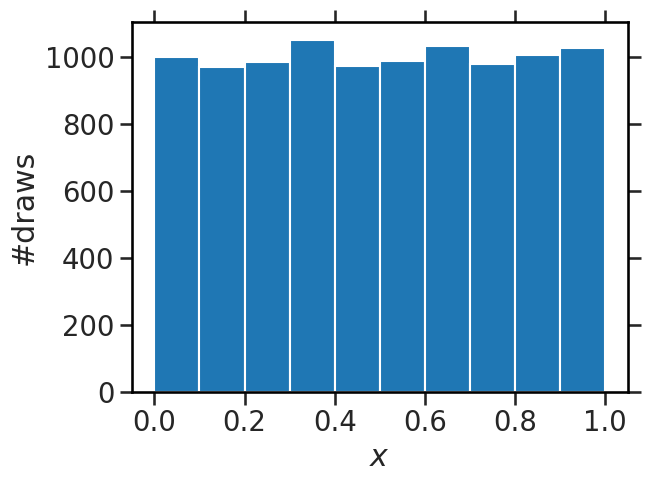

In [5]:
plt.hist(results)
plt.xlabel('$x$')
plt.ylabel('#draws');

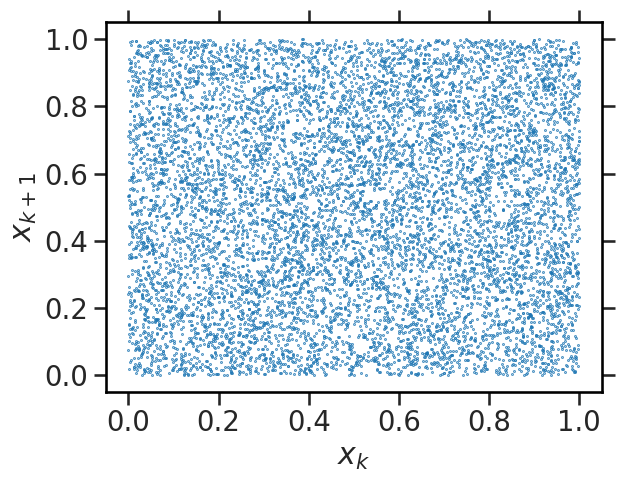

In [6]:
plt.scatter(results[:-1], results[1:], s=1, marker='.')
plt.xlabel('$x_k$')
plt.ylabel('$x_{k+1}$');

<p style="color:red;">$\implies$ what happens if you change the parameters $M,a,c$?</p>

Try e.g. $a=5$ or $\hat{M}=M-1$...

<h2>Generation of Gaussian Normal Distributed Pseudo-random Numbers</h2>

<b>Box-Muller Method</b>: Generate $x,y$ with bi-variate Gaussian normal probability density function $f(x,y)=\frac{1}{2\pi}e^{\frac{1}{2}\left(x^2 + y^2\right)}$ from uniformly distributed random numbers $\xi_1,\xi_2\in[0,1)$,

$$\begin{align}
    x &= \sqrt{-2\ln(\xi_2)}\,\cos(2\pi\xi_1) \\
    y &= \sqrt{-2\ln(\xi_2)}\,\sin(2\pi\xi_1)
\end{align}$$

which can be derived by <b>direct inversion</b> of the cumulative distribution function of $f$.

In [7]:
prng_1 = RandomNumberGenerator(
    M=2**31 - 1, 
    a=7**5, 
    c=0, 
    seed=12345)

prng_2 = RandomNumberGenerator(
    M=2**31 - 1, 
    a=7**5, 
    c=0, 
    seed=42)

In [8]:
def generate_normal():
    xi1 = prng_1.generate()
    xi2 = prng_1.generate()
    r = np.sqrt(-2 * np.log(xi2))
    x = r * np.cos(2 * np.pi * xi1)
    y = r * np.sin(2 * np.pi * xi1)
    return x, y

In [9]:
results = np.array(
    [generate_normal() for i in range(10000)]
).flatten()

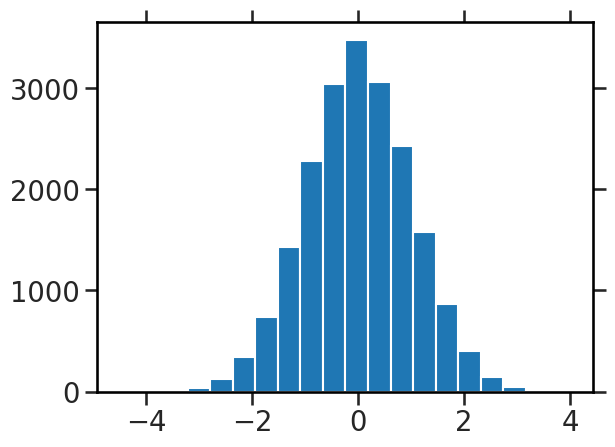

In [10]:
plt.hist(results, bins=20);


<h2>NumPy has it all...</h2>

The `numpy` library implements all of these (based on a better behaved variant of the linear congruential generator):

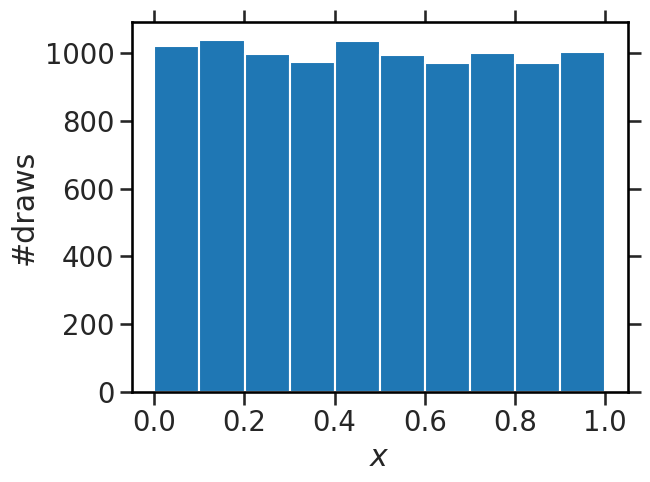

In [11]:
plt.hist(np.random.random(size=10000));
plt.xlabel('$x$')
plt.ylabel('#draws');

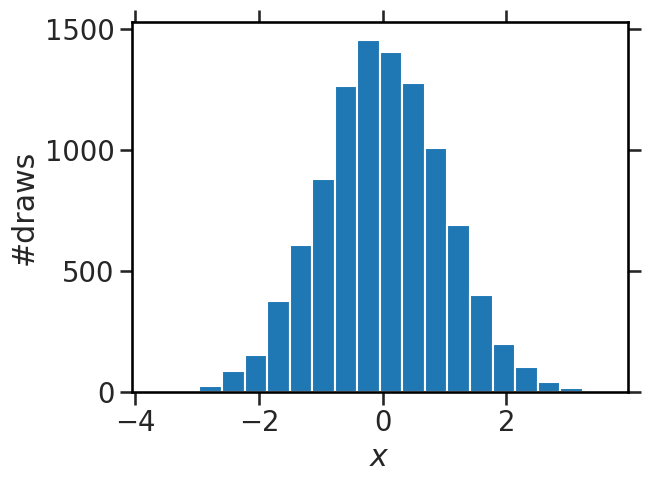

In [12]:
plt.hist(np.random.normal(size=10000), bins=20);
plt.xlabel('$x$')
plt.ylabel('#draws');

<div style="text-align: center; width:100%;">
    <h2>Part II: Hamiltonian and Longitudinal Dynamics</h2>
</div>

<h2>Longitudinal Differential Equations</h2>

The one-turn <b>difference map</b> for longitudinal tracking as per last lecture:

$$\left\{\begin{array}\,
    z_{n+1} &= z_n - \eta C \left(\cfrac{\Delta p}{p_0}\right)_n \\
    (\Delta p)_{n+1} &= (\Delta p)_n + \cfrac{q V}{(\beta c)_n}\cdot\left(\sin\left(\varphi_s - \cfrac{2\pi}{C}\cdot hz_{n+1}\right) - \sin(\varphi_s)\right)
\end{array}\right.$$

Treat <b>adiabatic acceleration</b> case ($\beta=\mathrm{const}$ during rf cavity kick) in <b>smooth focusing approximation</b> (rf cavity effect all around the ring):

$\implies$ obtain <b>differential equations</b> via $z_{n+1}-z_n\leadsto \frac{dz}{ds}\cdot C$ and $\Delta p_{n+1}-\Delta p_n \leadsto \frac{d(\Delta p)}{ds}\cdot C$

<div class="alert alert-block alert-success" style="text-align:center;">
$$\left\{\begin{array}\,
    \cfrac{dz}{ds} &= -\eta\cdot \cfrac{\Delta p}{p_0} \\
    \cfrac{d(\Delta p)}{ds} &= \cfrac{q V}{C\beta c}\cdot \left(\sin\left(\varphi_s - \cfrac{2\pi}{C}\cdot hz\right) - \sin(\varphi_s)\right)
\end{array}\right.$$
</div>

<h2>The Hamiltonian</h2>

To find (a sort of "instantaneous") $\mathcal{H}(z,\Delta p)=T(\Delta p) + U(z)$ which is conserved for const. $p_0,\beta,\gamma$, integrate Hamilton equations: 

The first equation determines the kinetic energy term $T(\Delta p)$

$$\begin{align}
    \frac{dz}{ds} &\stackrel{!}{=} \frac{\partial \mathcal{H}}{\partial (\Delta p)} \\
    \stackrel{\int}{\implies} \mathcal{H}(z,\Delta p) &= \underbrace{-\frac{1}{2}\frac{\eta}{p_0} \Delta p{}^2}\limits_{T} + U(z) + \mathrm{const.}
\end{align}$$

and the second equation 

$$\frac{d(\Delta p)}{ds} \stackrel{!}{=} -\frac{\partial\mathcal{H}}{\partial z}$$

determines the potential energy $U(z)$, such that the integration gives

<div class="alert alert-block alert-success" style="text-align:center;">
$$
    \mathcal{H}(z,\Delta p)=-\frac{1}{2}\frac{\eta}{p_0} \Delta p{}^2 - \frac{qV}{\beta c}\cdot\frac{1}{2\pi h}\left(\cos\left(\varphi_s - \frac{2\pi h}{C}\cdot z\right) - \frac{2\pi h}{C}\cdot z\cdot \sin(\varphi_s)\right)
$$
</div>

The CERN Proton Synchrotron (PS):
- has a circumference of 2π·100m
- takes protons from the PS Booster at a kinetic energy of 2GeV corresponding to a γ of 3.13
- injects with 50kV of rf voltage, up to 200kV for ramp
- runs at harmonic $h=7$
- has a momentum compaction factor of $\alpha_c=0.027$
- typical acceleration rate of (up to) $\dot{B}=2$ T/s, the bending radius is $\rho=70.08$ m

In [13]:
def beta(gamma):
    '''Speed β in units of c from relativistic Lorentz factor γ.'''
    return np.sqrt(1 - gamma**-2)

def gamma(p):
    '''Relativistic Lorentz factor γ from total momentum p.'''
    return np.sqrt(1 + (p / (mass * c))**2)

In [300]:
charge = e
mass = m_p

class Machine(object):
    gamma_ref = 3.13
    circumference = 2 * np.pi * 100
    voltage = 200e3
    harmonic = 7
    alpha_c = 0.027
    phi_s = 0.456
    
    def eta(self, deltap):
        '''Phase-slip factor for a particle.'''
        p = self.p0() + deltap
        return self.alpha_c - gamma(p)**-2

    def p0(self):
        '''Momentum of synchronous particle.'''
        return self.gamma_ref * beta(self.gamma_ref) * mass * c

    def update_gamma_ref(self):
        '''Advance the energy of the synchronous particle
        according to the synchronous phase by one turn.
        '''
        deltap_per_turn = charge * self.voltage / (
            beta(self.gamma_ref) * c) * np.sin(self.phi_s)
        new_p0 = self.p0() + deltap_per_turn
        self.gamma_ref = gamma(new_p0)

In [301]:
def T(deltap, machine):
    '''Kinetic energy term in Hamiltonian.'''
    return -0.5 * machine.eta(deltap) / machine.p0() * deltap**2

def U(z, machine, beta_=None):
    '''Potential energy term in Hamiltonian.
    If beta is not given, compute it from synchronous particle.
    '''
    m = machine
    if beta_ is None:
        beta_ = beta(gamma(m.p0()))
    ampl = charge * m.voltage / (beta_ * c * 2 * np.pi * m.harmonic)
    phi = m.phi_s - 2 * np.pi * m.harmonic / m.circumference * z
    # convenience: define z at unstable fixed point
    z_ufp = -m.circumference * (np.pi - 2 * m.phi_s) / (2 * np.pi * m.harmonic)
    # convenience: offset by potential value at unstable fixed point
    # such that unstable fixed point (and separatrix) have 0 potential energy
    return ampl * (-np.cos(phi) + 
                   2 * np.pi * m.harmonic / m.circumference * (z - z_ufp) * np.sin(m.phi_s) +
                   -np.cos(m.phi_s))

In [302]:
def hamiltonian(z, deltap, machine):
    return T(deltap, machine) + U(z, machine, beta_=beta(gamma(machine.p0() + deltap)))

In [303]:
def track_one_turn(z_n, deltap_n, machine):
    m = machine
    # half drift
    z_nhalf = z_n - m.eta(deltap_n) * deltap_n / m.p0() * m.circumference / 2
    # rf kick
    amplitude = charge * m.voltage / (beta(gamma(m.p0())) * c)
    phi = m.phi_s - m.harmonic * 2 * np.pi * z_nhalf / m.circumference
    
    m.update_gamma_ref()
    deltap_n1 = deltap_n + amplitude * (np.sin(phi) - np.sin(m.phi_s))
    # half drift
    z_n1 = z_nhalf - m.eta(deltap_n1) * deltap_n1 / m.p0() * m.circumference / 2
    return z_n1, deltap_n1

In [304]:
m = Machine()

In [305]:
def plot_hamiltonian(machine, zleft=-50, zright=50, dpmax=0.01, cbar=True):
    '''Plot Hamiltonian contours across (zleft, zright) and (-dpmax, dpmax).'''
    Z, DP = np.meshgrid(np.linspace(zleft, zright, num=1000), 
                        np.linspace(-dpmax, dpmax, num=1000))
    H = hamiltonian(Z, DP * machine.p0(), machine) / machine.p0()
    
    plt.contourf(Z, DP, H, cmap=plt.get_cmap('hot_r'), levels=12,
                 zorder=0, alpha=0.5)
    plt.xlabel('$z$ [m]')
    plt.ylabel(r'$\delta$')
    if cbar:
        colorbar = plt.colorbar(label=r'$\mathcal{H}(z,\Delta p)\,/\,p_0$')
        colorbar.ax.axhline(0, lw=2, c='b')
    plt.contour(Z, DP, H, colors='b', linewidths=2, levels=[0])

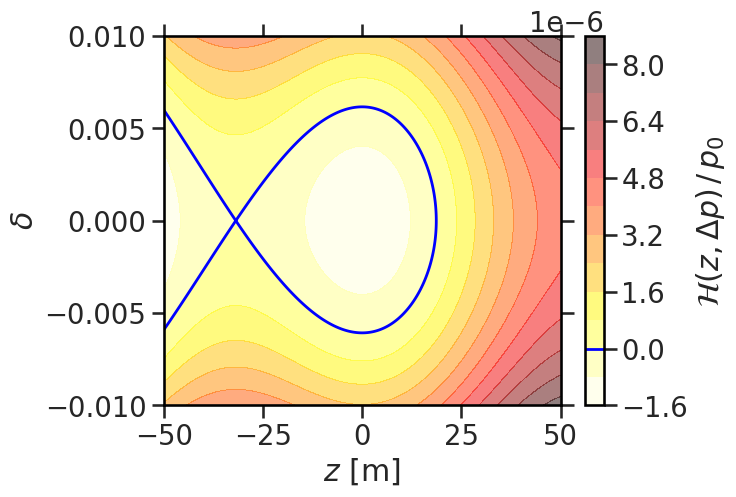

In [306]:
plot_hamiltonian(m)

Tracking just like last lecture:

In [307]:
n_turns = 500
deltap_ini = np.linspace(0, 0.01 * m.p0(), 20)
z_ini = np.zeros_like(deltap_ini)

N = len(z_ini)
assert (N == len(deltap_ini))

In [308]:
z = np.zeros((n_turns, N), dtype=np.float64)
deltap = np.zeros_like(z)

z[0] = z_ini
deltap[0] = deltap_ini

In [309]:
gammas = np.zeros(n_turns, dtype=np.float64)
gammas[0] = m.gamma_ref

In [310]:
H_values = np.zeros_like(z)
H_values[0] = hamiltonian(z_ini, deltap_ini, m) / m.p0()

In [311]:
for i_turn in range(1, n_turns):
    z[i_turn], deltap[i_turn] = track_one_turn(z[i_turn - 1], deltap[i_turn - 1], m)
    gammas[i_turn] = m.gamma_ref
    H_values[i_turn] = hamiltonian(z[i_turn], deltap[i_turn], m) / m.p0()

Text(0, 0.5, '$\\gamma_{ref}$')

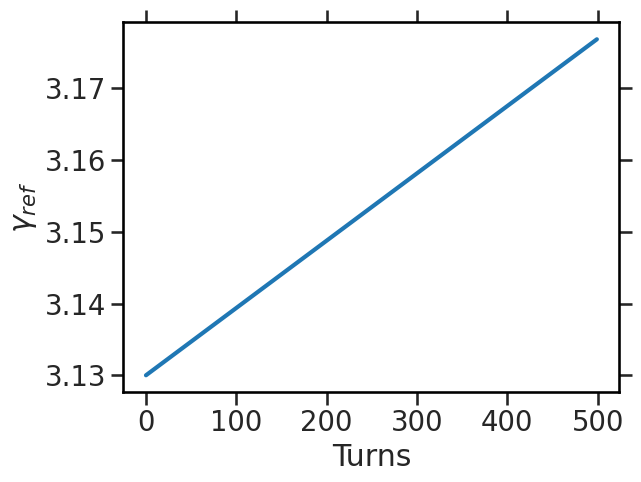

In [312]:
plt.plot(gammas)
plt.xlabel('Turns')
plt.ylabel('$\gamma_{ref}$')

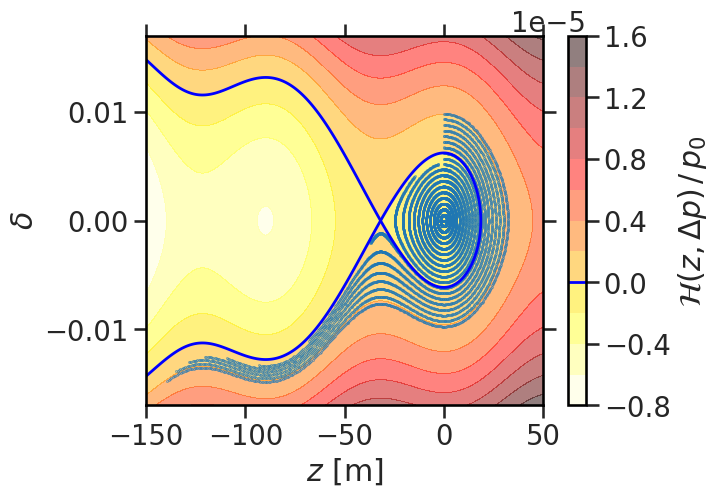

In [313]:
plt.scatter(z, deltap / m.p0(), marker='.', s=0.5)
plt.xlabel('$z$ [m]')
plt.ylabel('$\Delta p/p_0$')
plot_hamiltonian(m, zleft=-150, zright=50, dpmax=0.017)

Text(0, 0.5, '$\\mathcal{H}(z,\\Delta p)\\,/\\,p_0$')

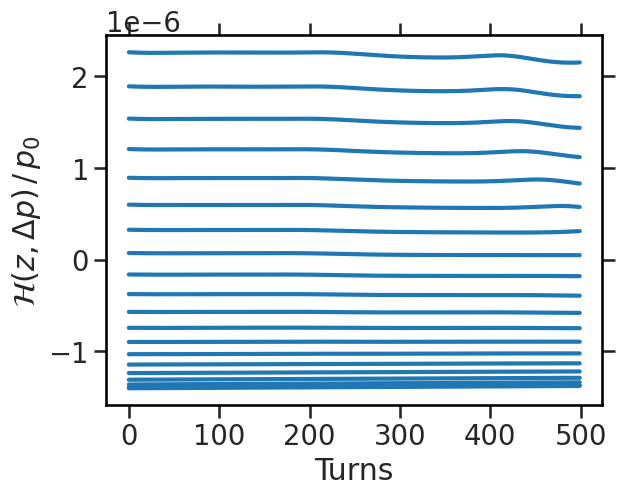

In [314]:
plt.plot(H_values, c='C0');
plt.xlabel('Turns')
plt.ylabel(r'$\mathcal{H}(z,\Delta p)\,/\,p_0$')

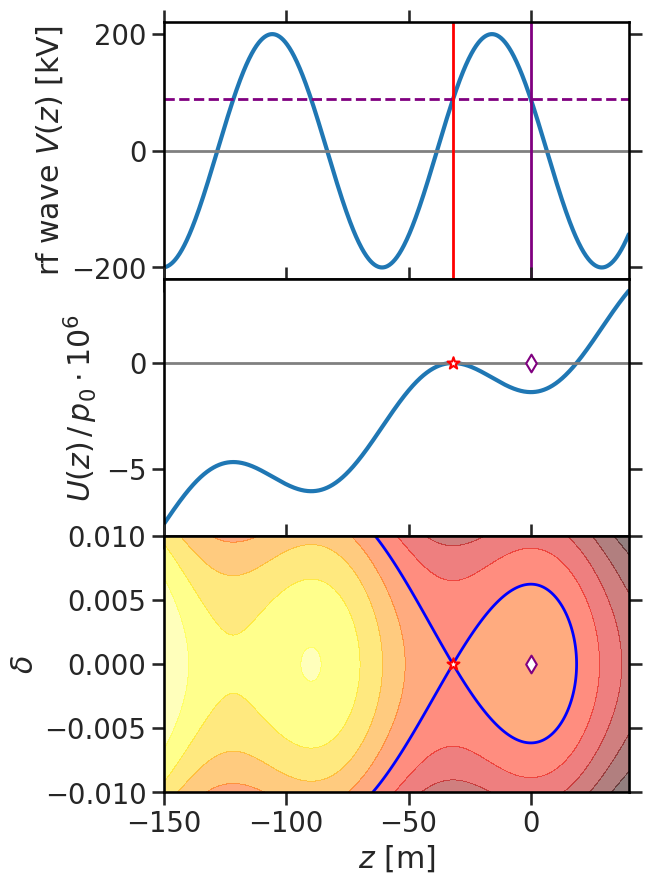

In [315]:
z_range = np.linspace(-150, 40, num=1000)
# z location of unstable fixed point:
z_ufp = -m.circumference * (np.pi - 2 * m.phi_s) / (2 * np.pi * m.harmonic)

fig, ax = plt.subplots(3, 1, figsize=(6, 10), sharex=True)

plt.sca(ax[0])
plt.plot(z_range, 1e-3 * m.voltage * np.sin(m.phi_s - 2 * np.pi * m.harmonic / m.circumference * z_range))
plt.axhline(0, c='gray', lw=2)
plt.axhline(1e-3 * m.voltage * np.sin(m.phi_s), c='purple', lw=2, ls='--')
plt.axvline(0, c='purple', lw=2)
plt.axvline(z_ufp, c='red', lw=2)
plt.ylabel('rf wave $V(z)$ [kV]')

plt.sca(ax[1])
plt.plot(z_range, 1e6 * U(z_range, m) / m.p0())
plt.axhline(0, c='gray', lw=2)
plt.ylabel(r'$U(z)\,/\,p_0\cdot 10^6$')

plt.scatter([z_ufp], [0], marker='*', c='white', edgecolor='red', zorder=10)
plt.scatter([0], [U(0, m) / m.p0()], marker='d', c='white', edgecolor='purple', zorder=10)

plt.sca(ax[2])
plot_hamiltonian(m, zleft=z_range[0], zright=z_range[-1], cbar=False)
plt.scatter([z_ufp], [0], marker='*', c='white', edgecolor='red', zorder=10)
plt.scatter([0], [0], marker='d', c='white', edgecolor='purple')
plt.xlabel('$z$ [m]')
plt.ylabel('$\delta$')
plt.subplots_adjust(hspace=0)

$\implies$ the closed area inside the blue separatrix is usually referred to as <b>rf bucket</b>!

<div style="text-align: center; width:100%;">
    <h2>Part III: Initialisation of Longitudinal Phase Space</h2>
</div>